In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
from torchvision.transforms import ToPILImage

In [34]:
# 加载数据
train_data=pd.read_csv("../../data/kaggle-Digit/train.csv")
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# 加载数据
test_data=pd.read_csv("../../data/kaggle-Digit/test.csv")
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
# 数据预处理，分离特征和标签
X = train_data.drop('label', axis=1).values  # 特征数据
y = train_data['label'].values  # 标签数据

In [37]:
# 归一化（将像素值缩放到0到1之间）
X = X / 255.0

# 将数据转换为PyTorch的Tensor格式
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

In [38]:
# 创建自定义Dataset类
class DigitDataset(Dataset):
    def __init__(self, features, labels, transform=None):
        self.features = features
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        image = self.features[idx].view(1, 28, 28)  # 转换为28x28的图像格式
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# # 数据增强
# transform = transforms.Compose([
#     transforms.Normalize((0.5,), (0.5,))  # 归一化
# ])

In [ ]:
# 数据增强的转换
transform = transforms.Compose([
    ToPILImage(),  # 转换为 PIL Image 格式
    transforms.RandomRotation(10),  # 随机旋转
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.ToTensor(),  # 转换为 Tensor 格式
    transforms.Normalize((0.5,), (0.5,))  # 归一化
])

In [40]:
# 创建训练和验证集的DataLoader
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = DigitDataset(train_X, train_y, transform)
val_dataset = DigitDataset(val_X, val_y, transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [41]:
# # 网络（多层感知器）
# class MLP(nn.Module):
#     def __init__(self):
#         super(MLP, self).__init__()
#         self.fc1 = nn.Linear(28*28, 128)  # 输入层：28x28 = 784个像素
#         self.fc2 = nn.Linear(128, 64)
#         self.fc3 = nn.Linear(64, 10)  # 输出层：10个数字（0-9）

#     def forward(self, x):
#         x = x.view(-1, 28*28)  # 展平：每个28x28的图像变成一维的784长度
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

In [42]:
# 多层MLP
class MLP(nn.Module):
    def __init__(self, input_size=28*28, hidden_sizes=[128, 64, 32], output_size=10):
        super(MLP, self).__init__()
        
        # 创建多个隐藏层
        layers = []
        previous_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(previous_size, hidden_size))  # 每个隐藏层
            layers.append(nn.ReLU())  # ReLU 激活函数
            layers.append(nn.Dropout(0.5))  # Dropout 防止过拟合
            previous_size = hidden_size
        
        # 输出层
        layers.append(nn.Linear(previous_size, output_size))
        
        # 将所有层连接起来
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 28*28)  # 展平每张图片
        return self.network(x)

In [43]:
# 3. CNN 网络（卷积神经网络）
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # 输入 1 通道，输出 32 通道
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # 输入 32 通道，输出 64 通道
        self.fc1 = nn.Linear(64*7*7, 128)  # 将特征展平成一维向量
        self.fc2 = nn.Linear(128, 10)  # 输出 10 个数字（0-9）

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)  # 下采样，减少图像尺寸
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)  # 下采样，减少图像尺寸
        x = x.view(-1, 64*7*7)  # 展平：将二维特征图展平成一维
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [44]:
# 4. 模型训练函数
def train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=20):
    train_losses = []
    val_losses = []  # 新增：验证损失
    model.to(device)  # 将模型转移到 GPU 或 CPU
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 将数据转移到 GPU 或 CPU
            
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()
        
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # 计算验证集损失
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
        
        avg_val_loss = running_val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")
    
    return train_losses, val_losses

In [45]:
def test_model(model, test_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # 计算准确率
    accuracy = 100 * sum(np.array(all_labels) == np.array(all_predictions)) / len(all_labels)
    
    # 计算精确率、召回率和F1分数
    precision = precision_score(all_labels, all_predictions, average='macro')  # 'macro' 是多分类的平均方式
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

In [46]:
# 6. 绘制损失曲线图
def plot_loss_curve(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [47]:
# 7. 运行实验
def run_experiment(model_class, learning_rate=0.001, num_epochs=20):
    # 检查设备（GPU 或 CPU）
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    model = model_class()
    criterion = nn.CrossEntropyLoss()
    # # 使用Adam优化器
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # 使用SGD优化器，设定学习率和动量
    # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    # 训练模型
    train_losses, val_losses = train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs)
    
    # 绘制损失曲线图
    plot_loss_curve(train_losses, val_losses)
    
    # 测试模型
    test_model(model, test_loader, device)
    


Running MLP experiment...
Using device: cuda
Epoch [1/40], Train Loss: 1.3590642795108614, Val Loss: 0.5993573559504567
Epoch [2/40], Train Loss: 0.8597959952127365, Val Loss: 0.45387470891529863
Epoch [3/40], Train Loss: 0.7624037127267747, Val Loss: 0.39280631799589505
Epoch [4/40], Train Loss: 0.6958394256092253, Val Loss: 0.3606159738970525
Epoch [5/40], Train Loss: 0.6525961682342347, Val Loss: 0.32456762100936787
Epoch [6/40], Train Loss: 0.6315013251418159, Val Loss: 0.32431711177482747
Epoch [7/40], Train Loss: 0.6111072544256846, Val Loss: 0.32040787697064155
Epoch [8/40], Train Loss: 0.5833306644644056, Val Loss: 0.3115376487487193
Epoch [9/40], Train Loss: 0.5724147024608793, Val Loss: 0.2924377273655299
Epoch [10/40], Train Loss: 0.5684616553215753, Val Loss: 0.2864610301048467
Epoch [11/40], Train Loss: 0.5599566701196489, Val Loss: 0.29203685734308127
Epoch [12/40], Train Loss: 0.5589739881810688, Val Loss: 0.27978728564851213
Epoch [13/40], Train Loss: 0.5418509065537226

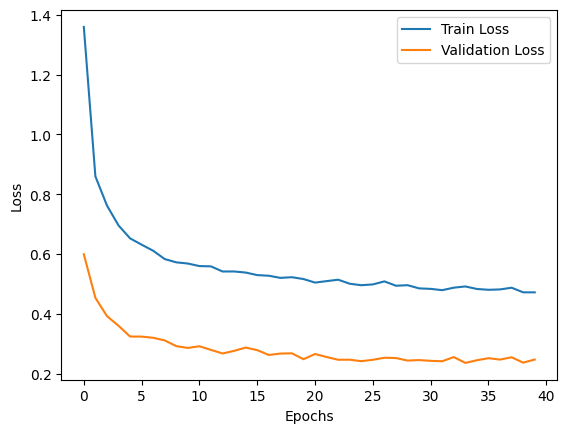

Test Accuracy: 92.99%
Precision: 0.9295
Recall: 0.9300
F1 Score: 0.9292


In [48]:
# 8. 运行 MLP 和 CNN 实验
print("Running MLP experiment...")
run_experiment(MLP, learning_rate=0.001, num_epochs=40)

# print("\nRunning CNN experiment...")
# run_experiment(CNN, learning_rate=0.001, num_epochs=20)